# OpenAI Gym


In [1]:
import logging
logging.basicConfig(format='%(levelname)s: %(message)s', level=logging.INFO)  # set level to INFO for wordy
import matplotlib.pyplot as plt
from IPython.display import HTML

import numpy as np
import jax.numpy as jnp

import gymnasium as gym

from extravaganza.dynamical_systems import Gym

from extravaganza.observables import TimeDelayedObservation, FullObservation, Trajectory
from extravaganza.sysid import Lifter, LiftedController, OfflineSysid
from extravaganza.controllers import LQR, HINF, BPC, GPC, RBPC, EvanBPC, ConstantController
from extravaganza.rescalers import ADAM, D_ADAM, DoWG, FIXED_RESCALE
from extravaganza.stats import Stats
from extravaganza.utils import ylim, render, append, opnorm, dare_gain, least_squares
from extravaganza.experiments import Experiment

# seeds for randomness. setting to `None` uses random seeds
SYSTEM_SEED = None
CONTROLLER_SEED = None
SYSID_SEED = None

INFO: Created a temporary directory at /var/folders/5m/0xr906c130vdqvkm3g21n6wr0000gn/T/tmpladxnhu_
INFO: Writing /var/folders/5m/0xr906c130vdqvkm3g21n6wr0000gn/T/tmpladxnhu_/_remote_module_non_scriptable.py


## System
Here, we work with games in the OpenAI gym, such as `MountainCarContinuous-v0`, in which we supply a value in `[-1, 1]` as a control to push a car left or right up a mountain. The tricky thing about this environment is that you first have to push the car up the left to gain momentum, even though the goal is on the right.

Another good environment is the `CartPole` enviroment (left and right bumps on a cart to keep an inverted pendulum upright), whose continuous analog is also displayed below.

We make use of **only the reward signal or cost function** to train, not using any state observation.

MountainCar | CartPole
- | - 
![mountaincar.gif](https://www.gymlibrary.dev/_images/mountain_car.gif) | ![cart_pole.gif](https://www.gymlibrary.dev/_images/cart_pole.gif)

## Hyperparameters

In [2]:
name = 'gymtesty'
filename = '../logs/{}.pkl'.format(name)

def get_experiment_args():
    # --------------------------------------------------------------------------------------
    # ------------------------    EXPERIMENT HYPERPARAMETERS    ----------------------------
    # --------------------------------------------------------------------------------------

    num_trials = 1
    T = 30000  # total timesteps
    T0 = 20000  # number of timesteps to just sysid for our methods
    reset_condition = lambda t: False  # when to reset the system
    use_multiprocessing = False
    render_every = None

    # --------------------------------------------------------------------------------------
    # --------------------------    SYSTEM HYPERPARAMETERS    ------------------------------
    # --------------------------------------------------------------------------------------

    du = 1
    ds = 4
    env_name = 'CartPoleContinuous-v1'  
    # env_name = 'MountainCarContinuous-v0'
    make_system = lambda : Gym(env_name=env_name, repeat=2, max_episode_len=600, seed=SYSTEM_SEED)

    # --------------------------------------------------------------------------------------
    # ------------------------    LIFT/SYSID HYPERPARAMETERS    ----------------------------
    # --------------------------------------------------------------------------------------
    
    dl = 16
    
#     observable = TimeDelayedObservation(hh = hh, state_dim=ds, control_dim=du, use_states=True, use_costs=True, use_controls=True, use_time=False)
#     observable = PartialObservation(obs_dim = 3, state_dim=ds, seed=SYSTEM_SEED)
    observable = FullObservation(state_dim=ds)
    do = observable.obs_dim
    
    sysid_args = {
        'obs_dim': ds,
        'control_dim': du,

        'max_traj_len': int(1e6),
        
        'AB_method': 'learned',
        
        'exploration_scales': 0.3,
        'exploration_bounds': (-1., 1.),

        'depth': 4,
        'sigma': 0,
        'determinstic_encoder': True,
        'num_epochs': 50,
        'lifter_lr': 0.003,                                                           

        'seed': SYSID_SEED,
    }

    # --------------------------------------------------------------------------------------
    # ------------------------    CONTROLLER HYPERPARAMETERS    ----------------------------
    # --------------------------------------------------------------------------------------

    h = 5  # controller memory length (# of w's to use on inference)
    m_update_rescaler = lambda : ADAM(0.001, betas=(0.9, 0.999))
    m0_update_rescaler = lambda : ADAM(0.00, betas=(0.9, 0.999))
    k_update_rescaler = lambda : ADAM(0.000, betas=(0.9, 0.999))

    nonlinear_bpc_args = {
        'h': h,  
        'method': 'REINFORCE',
        'initial_scales': (0, 0.1, 0),  # M, M0, K   (uses M0's scale for REINFORCE)
        'rescalers': (m_update_rescaler, m0_update_rescaler, k_update_rescaler),
        'bounds': None,
        'initial_u': jnp.zeros(du),
        'decay_scales': True,
        'use_tanh': False,
        'use_stabilizing_K': False,
        'seed': CONTROLLER_SEED
    }
    
    make_controllers = {
        'Lifted': lambda sys: OfflineSysid(lambda sysid: LiftedController(controller=EvanBPC(sysid.A, sysid.B, **nonlinear_bpc_args), lifter=sysid),
                                          sysid=Lifter(state_dim=dl, method='nn', **sysid_args), T0=T0)
    }

    experiment_args = {
        'make_system': make_system,
        'make_controllers': make_controllers,
        'observable': observable,
        'num_trials': num_trials,
        'T': T,
        'reset_condition': reset_condition,
        'reset_seed': SYSTEM_SEED,
        'use_multiprocessing': use_multiprocessing,
        'render_every': render_every,
    }
    return experiment_args

## actually run the thing :)

INFO: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO: Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
INFO: Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
INFO: (EXPERIMENT) --------------------------------------------------
INFO: (EXPERIMENT) ----------------- TRIAL 0 -----------------------
INFO: (EXPERIMENT) --------------------------------------------------

INFO: (EXPERIMENT): testing Lifted
/Users/evandigiorno/Desktop/extravaganza/env/lib/python3.10/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"

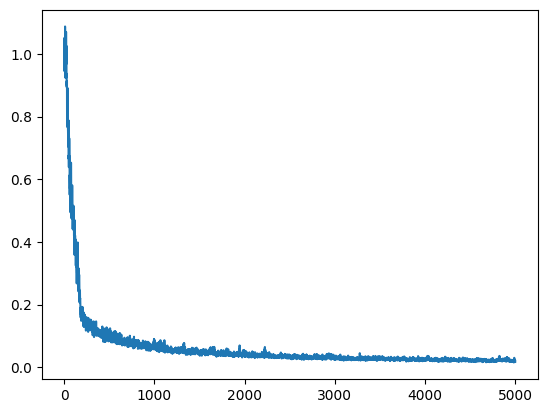

INFO: (PC3): using "learned" method to get the AB matrices during each training step
 67%|███████████████████████████████████████████████████▏                         | 19960/30000 [00:42<00:21, 469.30it/s, control=0.217, cost=0.0307]INFO: (SYSID WRAPPER) ending exploration at timestep 20000
INFO: (LIFTER): ending sysid phase at step 19999
INFO: training!
INFO: mean loss for epochs -2 - 0:
INFO: 		reconstruction: 0.0017137391074524787
INFO: 		l2 linearization: 0.005140904593671718
INFO: 		simplification: 0.00211429778968912
INFO: mean loss for epochs 0 - 2:
INFO: 		reconstruction: 0.0007920968596790359
INFO: 		l2 linearization: 0.0003055377365256423
INFO: 		simplification: 0.0007331951760203246
 67%|███████████████████████████████████████████████████▏                         | 19960/30000 [01:00<00:21, 469.30it/s, control=0.217, cost=0.0307]INFO: mean loss for epochs 2 - 4:
INFO: 		reconstruction: 0.000590162724244414
INFO: 		l2 linearization: 0.00029768424092196867
INFO: 		simplificat

||A||_op = 31.173906326293945
||B||_F = 0.04377438873052597
||A-BK||_op = 210.16110229492188


100%|████████████████████████████████████████████████████████████████████████████| 30000/30000 [05:26<00:00, 91.79it/s, control=0.0474, cost=0.00979]
INFO: 
INFO: (EXPERIMENT) done! The entire experiment took 336.2019542079943 seconds


In [3]:
# run
experiment = Experiment(name)
stats = experiment(get_experiment_args)

In [4]:
# save args and stats!  --  note that to save the args, we actually save the `get_args` function. we can print the 
#                           source code later to see the hyperparameters we chose
# experiment.save(filename)

## Visualization
We keep track of the useful information through `Stats` objects, which can `register()` a variable to keep track of (which it does via calls to `update()`) and which can be aggregated via `Stats.aggregate()` for mean and variance statistics. 

We define below a plotting arrangement that plots all the desired quantities from both the system and controller.

In [5]:
def plot_gym(experiment: Experiment):
    assert experiment.stats is not None, 'cannot plot the results of an experiment that hasnt been run'
    all_stats = experiment.stats
    
    # clear plot and calc nrows
    plt.clf()
    n = 3
    nrows = n + (len(all_stats) + 1) // 2
    fig, ax = plt.subplots(nrows, 2, figsize=(16, 6 * nrows))

    # plot stats
    for i, (method, stats) in enumerate(all_stats.items()):
        if stats is None: 
            logging.warning('{} had no stats'.format(method))
            continue
            
        stats.plot(ax[0, 0], 'true states', label=method, plot_idx=2)
        stats.plot(ax[1, 0], 'costs', label=method)
        stats.plot(ax[1, 1], 'costs', label=method, plot_cummean=True)
        
#         stats.plot(ax[2, 0], 'states', label=method, plot_norm=True)  # norm of the "state"
        for j in range(16):
            stats.plot(ax[2, 0], 'states', label=method + ' {}'.format(j), plot_idx=j)
        stats.plot(ax[2, 1], 'linearization', label='linearization')  # various nn losses
        stats.plot(ax[2, 1], 'simplification', label='simplification')
        stats.plot(ax[2, 1], 'reconstruction', label='reconstruction')
        stats.plot(ax[2, 1], 'controllability', label='controllability')
            
        i_ax = ax[n + i // 2, i % 2]
        for j in range(16):
            stats.plot(ax[0, 1], 'disturbances', label=method + ' {}'.format(j), plot_idx=j)
        stats.plot(i_ax, '-K @ state', label='-K @ state', plot_idx=0)
        stats.plot(i_ax, 'M \cdot w', label='M \cdot w', plot_idx=0)
        stats.plot(i_ax, 'M0', label='M0', plot_idx=0)
        i_ax.set_title('u decomp for {}'.format(method))
        i_ax.legend()

    # set titles and legends and limits and such
    # (note: `ylim()` is so useful! because sometimes one thing blows up and then autoscale messes up all plots)
    _ax = ax[0, 0]; _ax.set_title('true states'); _ax.legend()
    _ax = ax[0, 1]; _ax.set_title('disturbances'); _ax.legend()
    _ax = ax[1, 0]; _ax.set_title('instantaneous costs'); _ax.legend()
    _ax = ax[1, 1]; _ax.set_title('avg costs'); _ax.legend(); ylim(_ax, 0, 3)
    _ax = ax[2, 0]; _ax.set_title('reconstructed states'); _ax.legend()
    _ax = ax[2, 1]; _ax.set_title('nn losses'); _ax.legend()  
    pass

### Plot

ERROR: (STATS) l2 linearization was not plottable
ERROR: (STATS) l1 linearization was not plottable
ERROR: (STATS) reconstruction was not plottable
ERROR: (STATS) cpc was not plottable
ERROR: (STATS) guess the control was not plottable
ERROR: (STATS) simplification was not plottable
ERROR: (STATS) residual centeredness was not plottable
ERROR: (STATS) centeredness was not plottable


<Figure size 640x480 with 0 Axes>

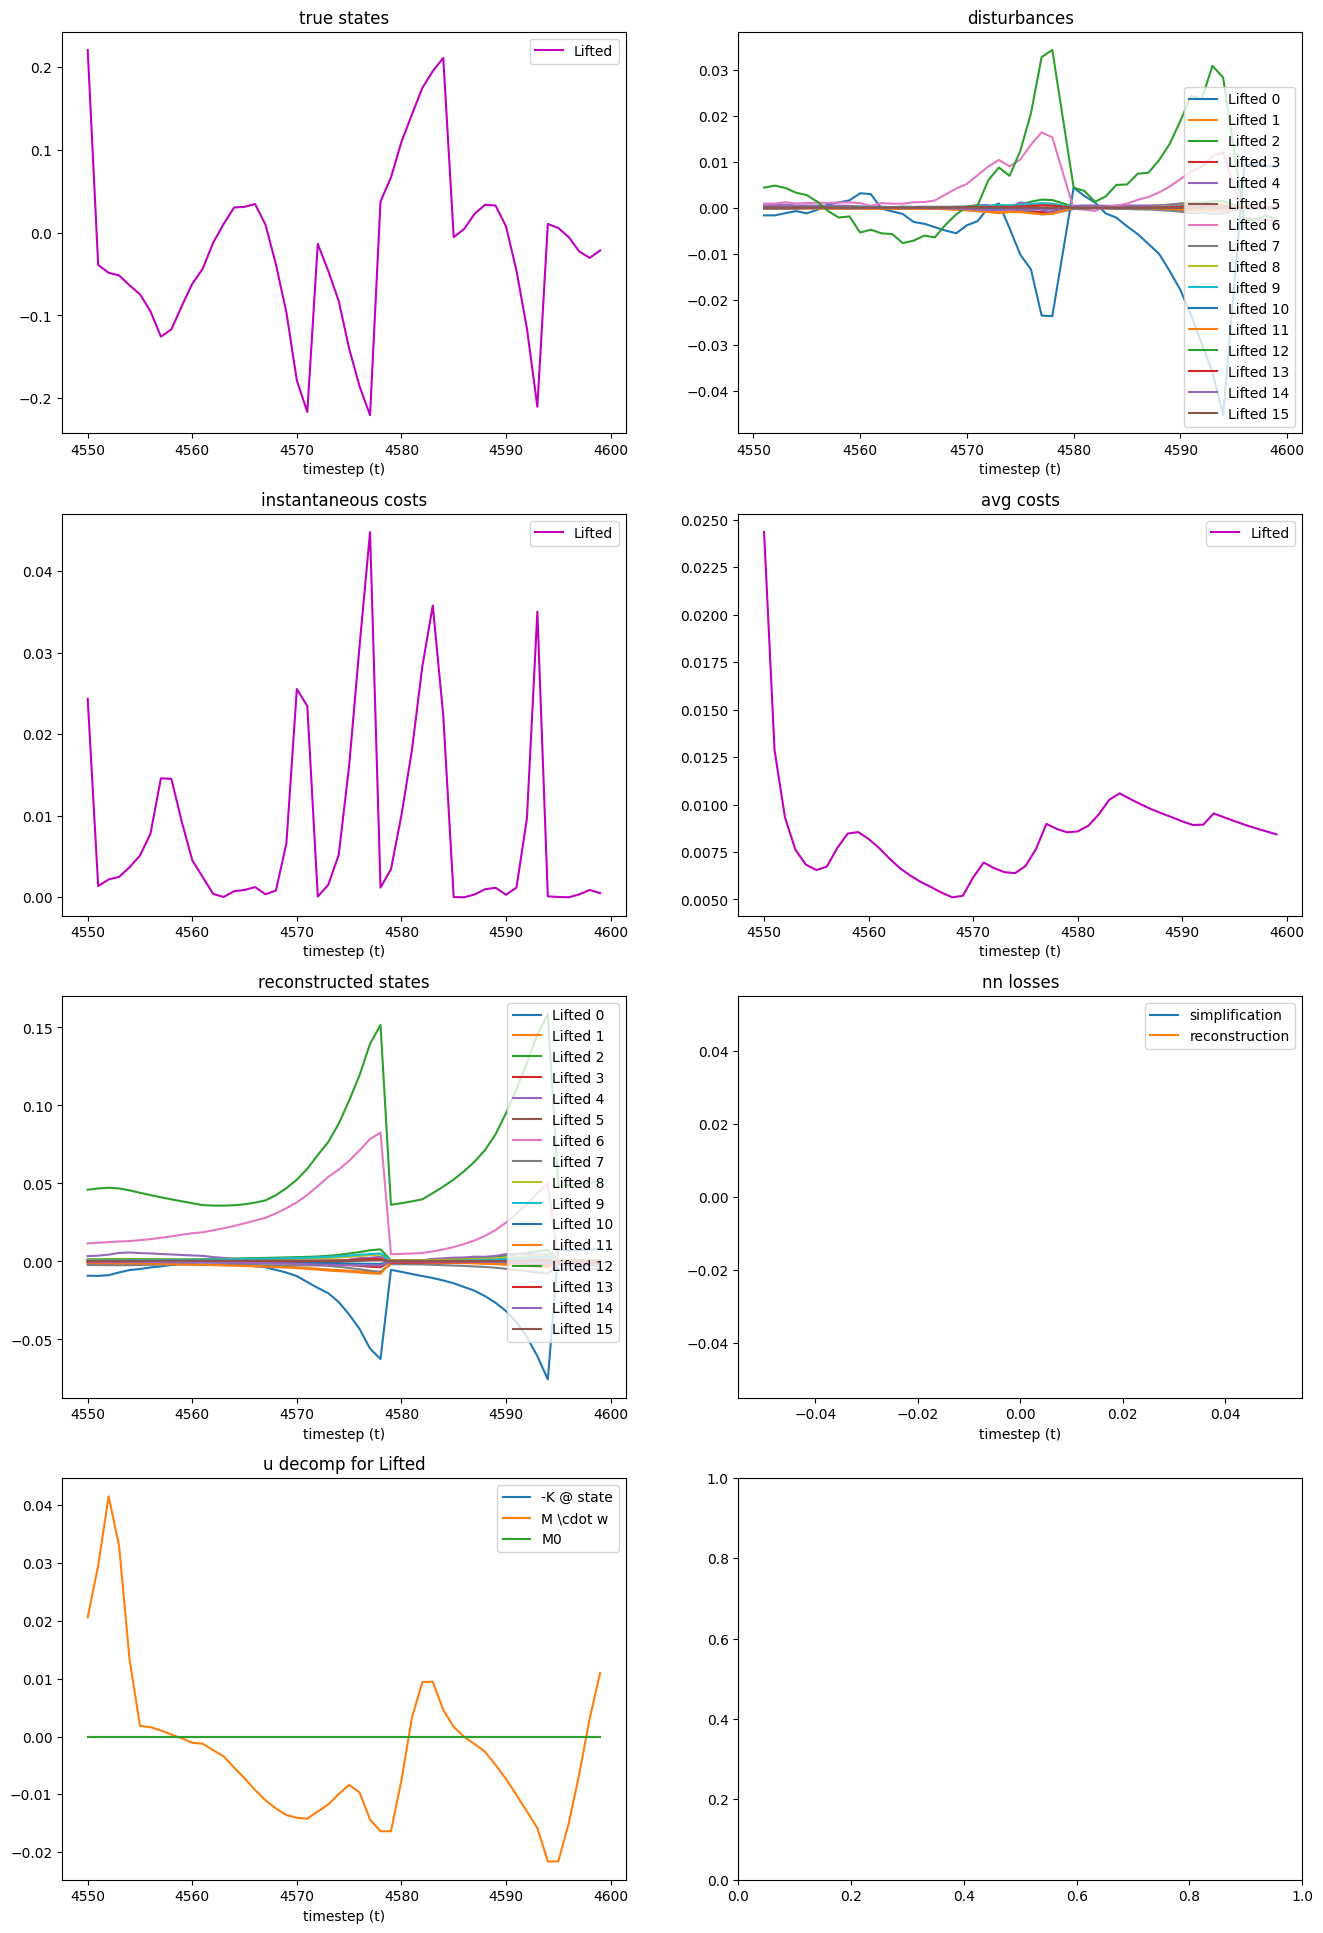

In [6]:
plot_gym(experiment[4550:4600])